In [1]:
import sys
sys.path.append("..")
from utils import load_data
from train import train_gfnn, test_regression
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [22]:
from collections import Counter

In [3]:
def rayleigh_i(X, M, index=0):
    r = X[:,index].unsqueeze(0) @ torch.spmm(M, X[:,index].unsqueeze(1))
    d = torch.norm(X[:,index], p=2).item()**2
    if d == 0.0:
        return 0
    return r.item() / d

In [4]:
def feature_transform(adj, X, k=1):
    for i in range(k):
        X = torch.spmm(adj, X)
    return X

In [5]:
def fourier_filter(U, X, indices=(0,100)):
    i, j = indices
    coeff = U[:,i:j].transpose(0,1) @ X
    X_hat = U[:,i:j] @ coeff
    return X_hat

In [52]:
def print_info(dname):
    gnx, normed_adj, X, y, idx_train, idx_val, idx_test = \
            load_data(dname, [''], split="default")
    print("Num nodes:", gnx.number_of_nodes())
    print("Num edges:", gnx.number_of_edges())
    print("Num comps:", nx.number_connected_components(gnx))
    p = max(nx.connected_components(gnx), key=len)
    print("Largest connected component: {}, {}".format(gnx.subgraph(p).number_of_nodes(), 
                                                       gnx.subgraph(p).number_of_edges()))
    print("Num class:", max(y).item()+1)
    print("Split: {}/{}/{}".format(len(idx_train), len(idx_val), len(idx_test)))
    print("Class ratio (train):")
    count_class = Counter(y[idx_train].numpy())
    m = max(1, min(count_class.values()))
    for cls, cnt in count_class.items():
        print(cls, cnt/m)
    print("Class ratio (test):")
    count_class = Counter(y[idx_test].numpy())
    m = max(1, min(count_class.values()))
    for cls, cnt in count_class.items():
        print(cls, cnt/m)
    print("Feature dim:", X.shape[1])

In [46]:
print_info("cora")

Num nodes: 2708
Num edges: 5278
Num comps: 78
Largest connected component: 2485, 5069
Num class: 7
Split: 140/500/1000
Class ratio (train):
3 1.0
4 1.0
0 1.0
2 1.0
1 1.0
5 1.0
6 1.0
Class ratio (test):
3 4.984375
2 2.25
0 2.03125
1 1.421875
5 1.609375
4 2.328125
6 1.0
Feature dim: 1433


In [47]:
print_info("citeseer")

Num nodes: 3327
Num edges: 4676
Num comps: 438
Largest connected component: 2120, 3731
Num class: 6
Split: 120/500/1000
Class ratio (train):
3 1.0
1 1.0
5 1.0
0 1.0
2 1.0
4 1.0
Class ratio (test):
4 2.1948051948051948
5 2.0779220779220777
1 2.3636363636363638
2 2.3506493506493507
3 3.0
0 1.0
Feature dim: 3703


../normalization.py:79: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [48]:
print_info("pubmed")

Num nodes: 19717
Num edges: 44327
Num comps: 1
Largest connected component: 19717, 44327
Num class: 3
Split: 60/500/1000
Class ratio (train):
1 1.0
0 1.0
2 1.0
Class ratio (test):
2 2.261111111111111
1 2.2944444444444443
0 1.0
Feature dim: 500


In [50]:
print_info("wisconsin")

Num nodes: 251
Num edges: 450
Num comps: 1
Largest connected component: 251, 450
Num class: 5
Split: 15/50/186
Class ratio (train):
0 1.0
2 1.0
3 1.0
4 1.0
1 1.0
Class ratio (test):
1 8.285714285714286
2 12.571428571428571
3 3.0
4 1.7142857142857142
0 1.0
Feature dim: 1703


In [51]:
print_info("cornell")

Num nodes: 183
Num edges: 277
Num comps: 1
Largest connected component: 183, 277
Num class: 5
Split: 13/50/120
Class ratio (train):
0 3.0
1 1.0
2 3.0
3 3.0
4 3.0
Class ratio (test):
0 2.888888888888889
2 1.0
3 7.111111111111111
4 2.3333333333333335
Feature dim: 1703


# Wisconsin

### A. Matching Rayleigh Quotient

In [53]:
gnx, normed_adj, X, y, idx_train, idx_val, idx_test = \
            load_data("wisconsin", ['', "RwNorm", "SymNormLap", "AbsRwNormAdj"], split="0.6_0.2_0.2")

In [54]:
gnx.number_of_edges(), gnx.number_of_nodes()

(450, 251)

In [55]:
X.shape

torch.Size([251, 1703])

In [56]:
yoh = F.one_hot(y, num_classes=5).float()

In [57]:
labels_r = np.array([rayleigh_i(yoh, normed_adj[2], i) for i in range(5)])
print("Mean: {}, Std: {}".format(labels_r.mean(), labels_r.std()))

Mean: 0.8711169809948902, Std: 0.08134907967383795


In [58]:
labels_r

array([0.88452995, 0.76565834, 0.95448948, 0.96147201, 0.78943512])

In [59]:
X_r = np.array([rayleigh_i(X, normed_adj[2], i) for i in range(1703)])
print("Mean: {}, Std: {}".format(X_r.mean(), X_r.std()))

Mean: 0.8875631225248181, Std: 0.22910043780401002


In [60]:
X_RwNorm = feature_transform(normed_adj[1], X, k=1)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(1703)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.5578994116868834, Std: 0.19553867073133502


In [61]:
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[1], i) for i in range(1703)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.6357707181787869, Std: 0.1792337162606236


In [62]:
X_AbsRwNormAdj = feature_transform(normed_adj[3], X, k=1)
X_AbsRwNormAdj_r = np.array([rayleigh_i(X_AbsRwNormAdj, normed_adj[2], i) for i in range(1703)])
print("Mean: {}, Std: {}".format(X_AbsRwNormAdj_r.mean(), X_AbsRwNormAdj_r.std()))

Mean: 0.5578994116868834, Std: 0.19553867073133502


In [63]:
X_RwNorm = feature_transform(normed_adj[1], X, k=2)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(1703)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.395488923841463, Std: 0.16178651837992697


Note: The filter makes the feature matches the rayleight quotient of the labels 

### B.  Eigendecomposition

In [64]:
nx.number_connected_components(gnx)

1

In [65]:
l, v = np.linalg.eigh(nx.normalized_laplacian_matrix(gnx).A + 0.00001)
l[np.where(l < 1e-10)] = 0
idx = l.argsort()   
l = l[idx]
v = v[:,idx]

In [66]:
v = torch.Tensor(v).float()

In [67]:
rayleigh_i(v, normed_adj[2], 50)

0.5566598176956177

In [68]:
l.max()

1.910578874698238

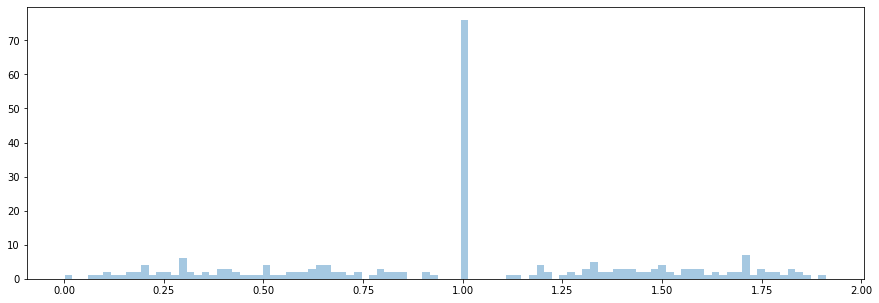

In [69]:
plt.figure(figsize=(15,5))
sns.distplot(l, bins=100, kde=False, rug=False)

In [70]:
clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=20000)
feat = fourier_filter(v, X, indices=(50, 150))
train_feat = feat[idx_train].numpy()
val_feat = feat[idx_val].numpy()
test_feat = feat[idx_test].numpy()

clf.fit(train_feat, y[idx_train])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [71]:
np.sum(clf.predict(test_feat) == y[idx_test].numpy()) / 1000

0.012

In [212]:
clf = SVC(C=10000.0)
# feat = fourier_filter(v, X, indices=(50, 150))
train_feat = X[idx_train].numpy()
val_feat = X[idx_val].numpy()
test_feat = X[idx_test].numpy()

clf.fit(train_feat, y[idx_train])

SVC(C=10000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [213]:
np.sum(clf.predict(test_feat) == y[idx_test].numpy()) / 1000

0.045

Fit filtered features

In [196]:
X_RwNorm = feature_transform(normed_adj[1], X, k=1)
clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=20000)
train_feat = X_RwNorm[idx_train].numpy()
val_feat = X_RwNorm[idx_val].numpy()
test_feat = X_RwNorm[idx_test].numpy()

clf.fit(train_feat, y[idx_train])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=20000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [197]:
np.sum(clf.predict(test_feat) == y[idx_test].numpy()) / 1000

0.026

# Citeseer

### A. Matching Rayleigh quotient

In [530]:
gnx, normed_adj, X, y, idx_train, idx_val, idx_test = \
            load_data("citeseer", ['', "RwNorm", "SymNormLap", "AbsRwNormAdj"])

../normalization.py:79: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [531]:
yoh = F.one_hot(y, num_classes=6).float()

In [532]:
labels_r = np.array([rayleigh_i(yoh, normed_adj[2], i) for i in range(6)])
print("Mean: {}, Std: {}".format(labels_r.mean(), labels_r.std()))

Mean: 0.37658795671073975, Std: 0.11117576443748893


In [533]:
labels_r

array([0.60458063, 0.37608983, 0.39446794, 0.28630787, 0.32804129,
       0.27004017])

In [534]:
X_r = np.array([rayleigh_i(X, normed_adj[2], i) for i in range(3703)])
print("Mean: {}, Std: {}".format(X_r.mean(), X_r.std()))

Mean: 0.8055648380693111, Std: 0.19417330372665548


In [535]:
X_RwNorm = feature_transform(normed_adj[1], X, k=1)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(3703)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.32037138477031735, Std: 0.13754224668649165


In [536]:
X_RwNorm = feature_transform(normed_adj[1], X, k=2)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(3703)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.17920855110772774, Std: 0.09094552240239674


### B. Eigendecomposition

In [537]:
nx.number_connected_components(gnx)

438

In [538]:
l, v = np.linalg.eigh(nx.normalized_laplacian_matrix(gnx).A + 0.0001)
l[np.where(l < 1e-10)] = 0
idx = l.argsort()   
l = l[idx]
v = v[:,idx]

In [545]:
v = torch.Tensor(v).float()
rayleigh_i(v, normed_adj[2], 1000)

0.5114935520000037

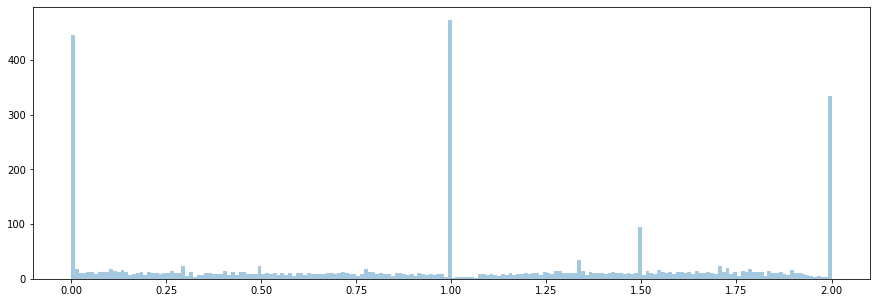

In [546]:
plt.figure(figsize=(15,5))
sns.distplot(l, bins=200, kde=False, rug=False)

# Pubmed

### A. Matching Rayleigh quotient

In [515]:
gnx, normed_adj, X, y, idx_train, idx_val, idx_test = \
            load_data("pubmed", ['', "RwNorm", "SymNormLap", "AbsRwNormAdj"])

In [517]:
yoh = F.one_hot(y, num_classes=6).float()
labels_r = np.array([rayleigh_i(yoh, normed_adj[2], i) for i in range(6)])
print("Mean: {}, Std: {}".format(labels_r.mean(), labels_r.std()))

Mean: 0.2543236723254429, Std: 0.2554629888099532


In [518]:
X_r = np.array([rayleigh_i(X, normed_adj[2], i) for i in range(500)])
print("Mean: {}, Std: {}".format(X_r.mean(), X_r.std()))

Mean: 0.8671004615600176, Std: 0.07000272088299465


In [520]:
X_RwNorm = feature_transform(normed_adj[1], X, k=1)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(500)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.6916697668831758, Std: 0.07310921154793198


In [522]:
X_RwNorm = feature_transform(normed_adj[1], X, k=2)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(500)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.4986617145943691, Std: 0.04280482903423631


In [529]:
X_RwNorm = feature_transform(normed_adj[1], X, k=40)
X_RwNorm_r = np.array([rayleigh_i(X_RwNorm, normed_adj[2], i) for i in range(500)])
print("Mean: {}, Std: {}".format(X_RwNorm_r.mean(), X_RwNorm_r.std()))

Mean: 0.3719364095902638, Std: 0.015110402967608908


# Cora

In [72]:
gnx, normed_adj, X, y, idx_train, idx_val, idx_test = \
            load_data("cora", ['', "RwNorm", "SymNormLap", "AbsRwNormAdj"])

In [74]:
largest = max(nx.connected_components(gnx), key=len)

In [75]:
cora = gnx.subgraph(largest)

In [78]:
nx.diameter(cora)

19